In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils

In [2]:
# Load results of the fitting procedure (alexnet features, main pRFs used for all analyses)

subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'alexnet_all_conv_pca'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, verbose=False) \
       for ss in subjects]
fig_save_folder=None

In [3]:
# Load results of the fitting procedure (different feature set for comparison)

subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf_fit_pRFs'

out_gabor = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, verbose=False) \
       for ss in subjects]
fig_save_folder=None

In [4]:
skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

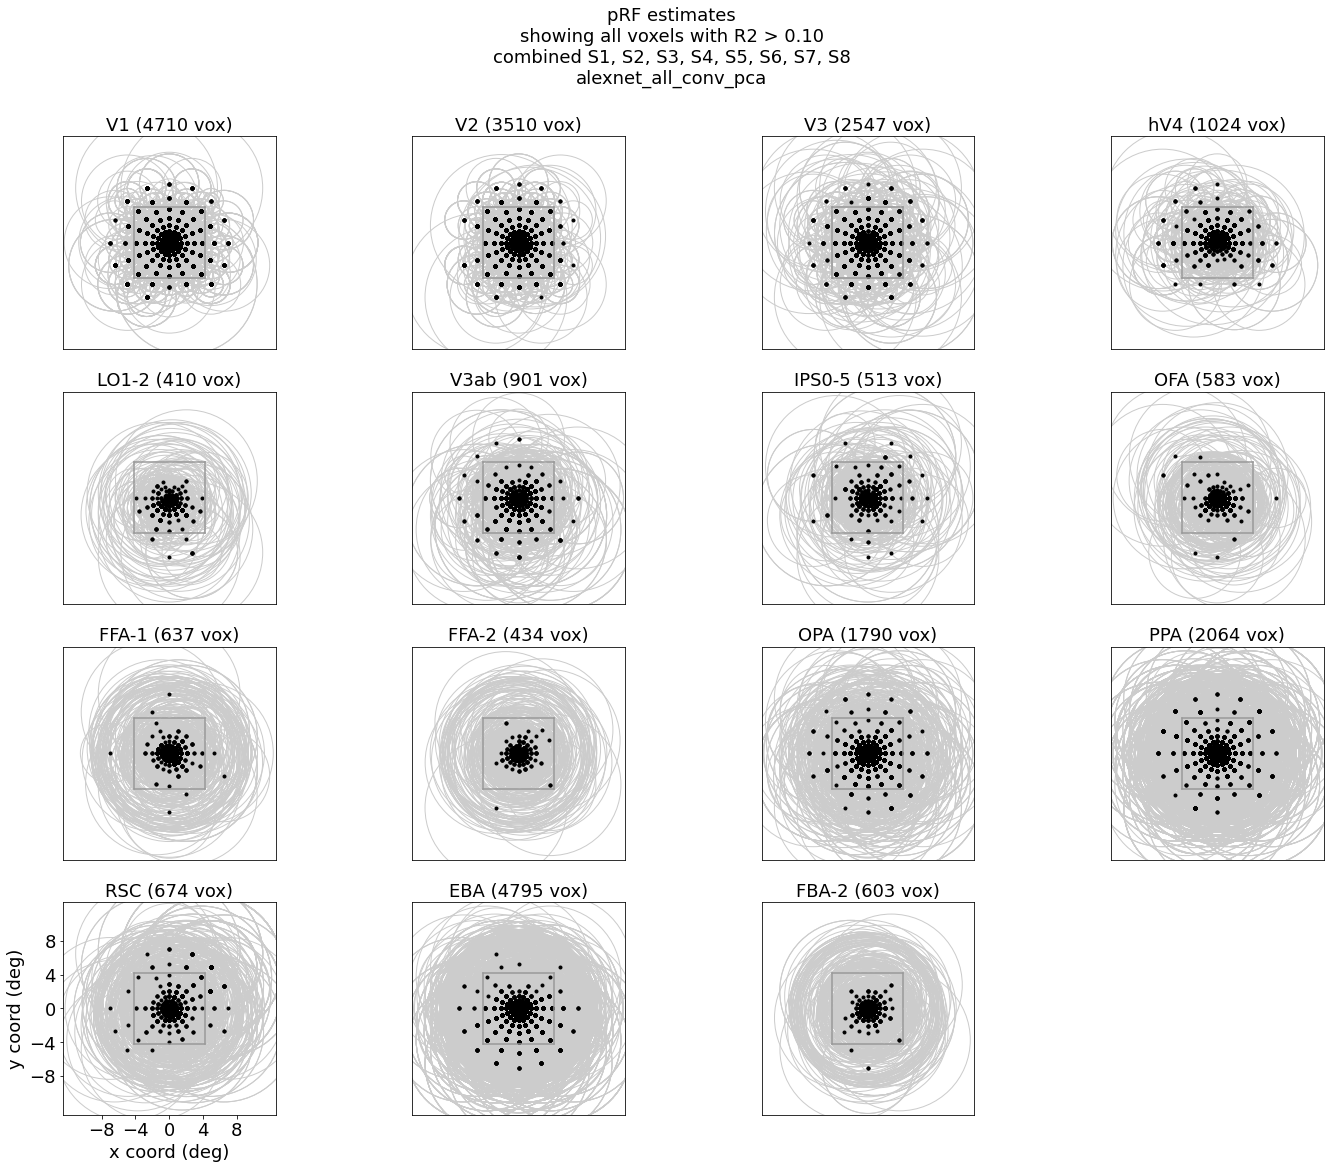

In [3]:
# this cell is slow to run!!

plot_utils.set_all_font_sizes(fs = 18)
plot_prf_params.plot_spatial_rf_circles(fitting_type,out, roi_def=roi_def, skip_inds=skip_inds,\
                                     r2_cutoff = 0.10, fig_save_folder=fig_save_folder)

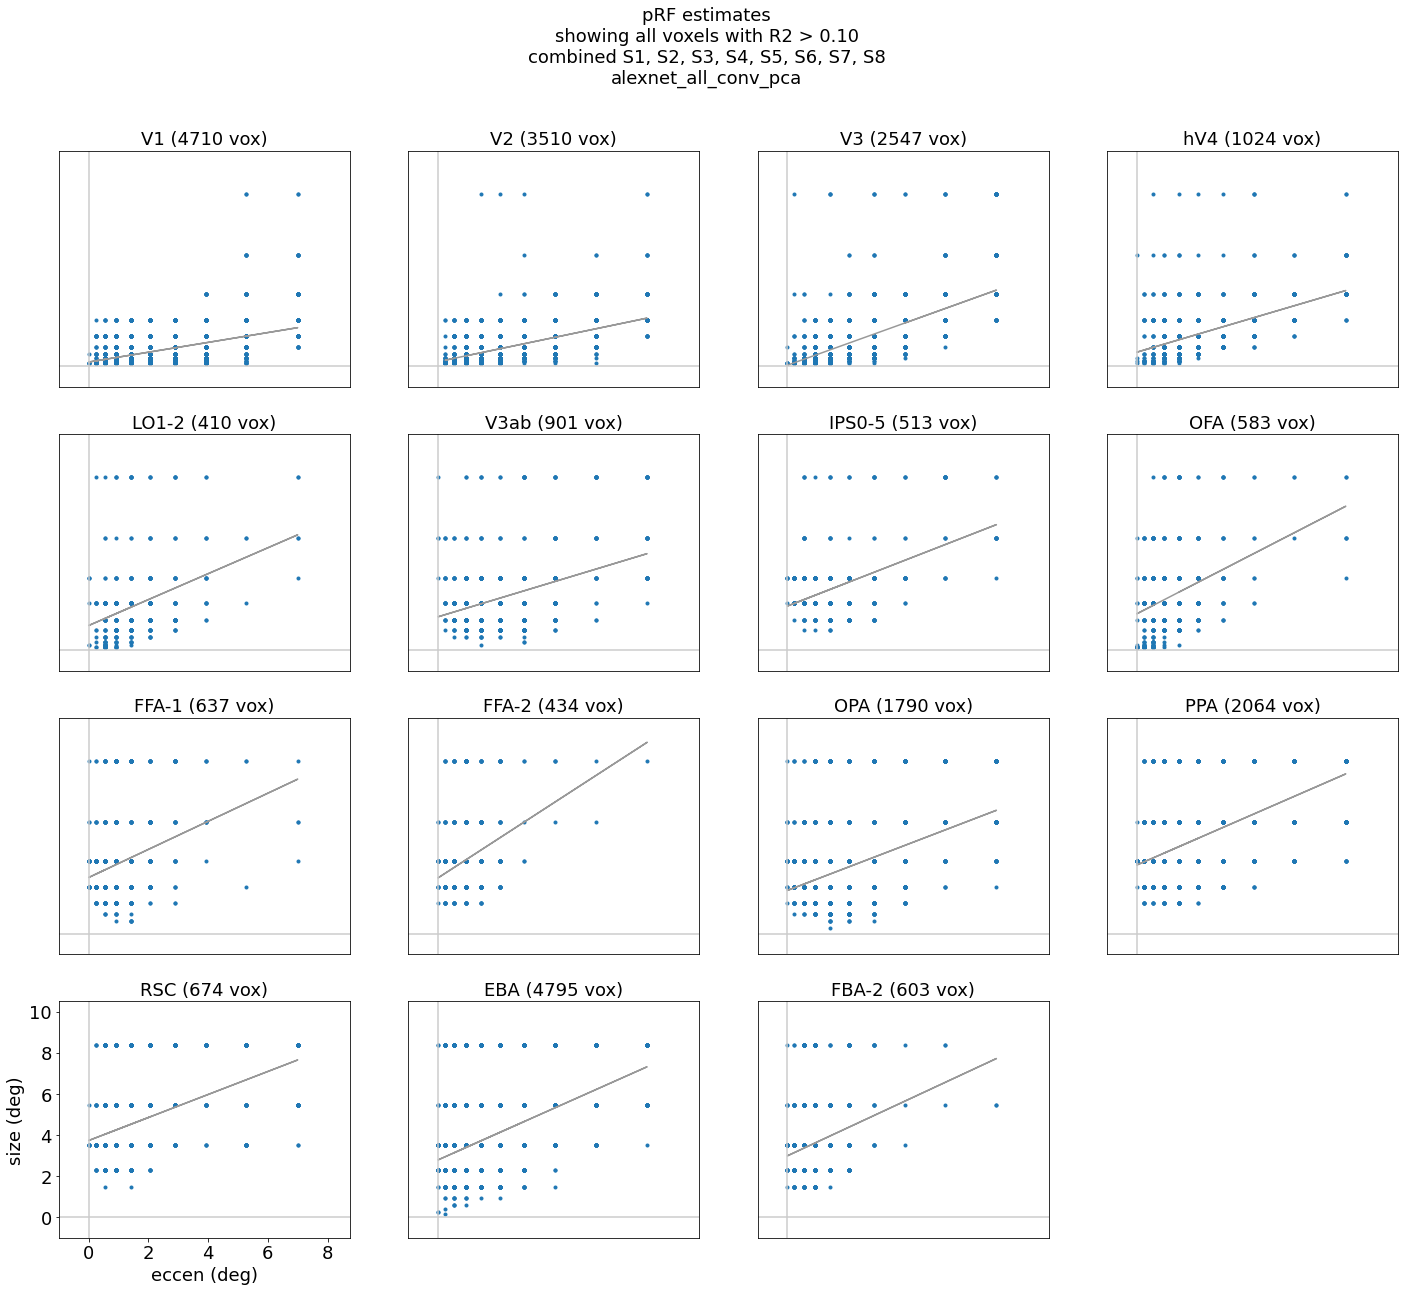

In [3]:
# this cell is slow to run!!

plot_utils.set_all_font_sizes(fs = 18)
plot_prf_params.plot_size_vs_eccen(fitting_type, out, roi_def=roi_def, skip_inds=skip_inds, \
                                   r2_cutoff=0.10, fig_save_folder=fig_save_folder)

In [21]:
# loading pRF parameters from independent mapping task data

from utils import nsd_utils

angle_mapping = []
eccen_mapping = []
size_mapping = []
rsq_mapping = []

for si,ss in enumerate(subjects):
    
    voxel_mask = roi_def.ss_roi_defs[si].voxel_mask
    a,e,s, exp,gain,rsq = nsd_utils.load_prf_mapping_pars(subject=ss, \
                                                      voxel_mask = voxel_mask)
    angle_mapping.append(a)
    eccen_mapping.append(e)
    size_mapping.append(s)
    rsq_mapping.append(rsq)
    
# these are in degrees
angle_mapping = np.concatenate(angle_mapping)
eccen_mapping = np.concatenate(eccen_mapping)
size_mapping = np.concatenate(size_mapping)
rsq_mapping = np.concatenate(rsq_mapping)

x_mapping, y_mapping = prf_utils.pol_to_cart(angle_mapping, eccen_mapping)

In [9]:
# compare to pars from my model
from utils import prf_utils

prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = sigma * screen_eccen_deg


In [13]:
# and another version of my model

prf_pars_gabor = np.concatenate([out_gabor[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x_gabor = prf_pars_gabor[:,0]
y_gabor= prf_pars_gabor[:,1]
sigma_gabor = prf_pars_gabor[:,2]

screen_eccen_deg = 8.4
angle_fwrf_gabor, eccen_fwrf_gabor = prf_utils.cart_to_pol(x_gabor*screen_eccen_deg,\
                                                           y_gabor*screen_eccen_deg)
size_fwrf_gabor = sigma_gabor * screen_eccen_deg

rsq_fwrf_gabor = np.concatenate([out_gabor[si]['val_r2'][:,0] \
                                 for si in range(n_subjects)], axis=0)


In [14]:
# don't count angle for RFs that are at the fovea
no_angle = (eccen_mapping<10e-2) | (eccen_fwrf<10e-2) | (eccen_fwrf_gabor<10e-2)
np.sum(no_angle)

27433

In [16]:
# Compare alexnet-FWRF params vs mapping task params

from utils import circ_utils

angle_corrs = np.zeros((n_rois,))
ecc_corrs = np.zeros((n_rois,))
x_corrs = np.zeros((n_rois,))
y_corrs = np.zeros((n_rois,))
size_corrs = np.zeros((n_rois,))

n_good_vox = np.zeros((n_rois,))

val_r2 = np.concatenate([out[si]['val_r2'] for si in range(n_subjects)], axis=0)

r2_thresh = 0.10

for ri in range(n_rois):
    
    # only include voxels here that pass a threshold for both 
    # mapping task var explained, and FWRF model var explained.
    
    vinds = roi_def.get_indices(ri) & \
            (val_r2[:,0]>r2_thresh) & (rsq_mapping>r2_thresh)
    
    n_good_vox[ri] = np.sum(vinds)
    
    if np.sum(vinds)==0:
        angle_corrs[ri] = np.nan
        ecc_corrs[ri] = np.nan
        size_corrs[ri] = np.nan
        continue
        
    # removing the 0-eccen voxels for angle correlation
    angle_corrs[ri] = circ_utils.circ_corr_coef(angle_fwrf[vinds & ~no_angle]/180*np.pi, \
                                                angle_mapping[vinds & ~no_angle]/180*np.pi)

    ecc_corrs[ri] = np.corrcoef(eccen_fwrf[vinds], eccen_mapping[vinds])[0,1]
    size_corrs[ri] = np.corrcoef(size_fwrf[vinds], size_mapping[vinds])[0,1]

In [17]:
import pandas as pd

prf_comparison = pd.DataFrame({'n voxels': n_good_vox.astype(int), \
                               'circ corr b/w angles': angle_corrs.round(2), \
                               'corr b/w eccens': ecc_corrs.round(2),\
                               'corr b/w sizes': size_corrs.round(2),\
                               }, index = roi_names)
prf_comparison

,n voxels,circ corr b/w angles,corr b/w eccens,corr b/w sizes
V1,4581,0.92,0.74,0.17
V2,3408,0.93,0.77,0.24
V3,2479,0.92,0.66,0.38
hV4,1003,0.85,0.54,0.40
LO1-2,338,0.70,0.43,0.25
V3ab,803,0.68,0.27,0.17
IPS0-1,304,0.32,0.40,-0.00
IPS2-5,28,-0.40,-0.01,-0.33
OPA,1128,0.47,0.27,0.03
PPA,378,0.25,-0.01,-0.10


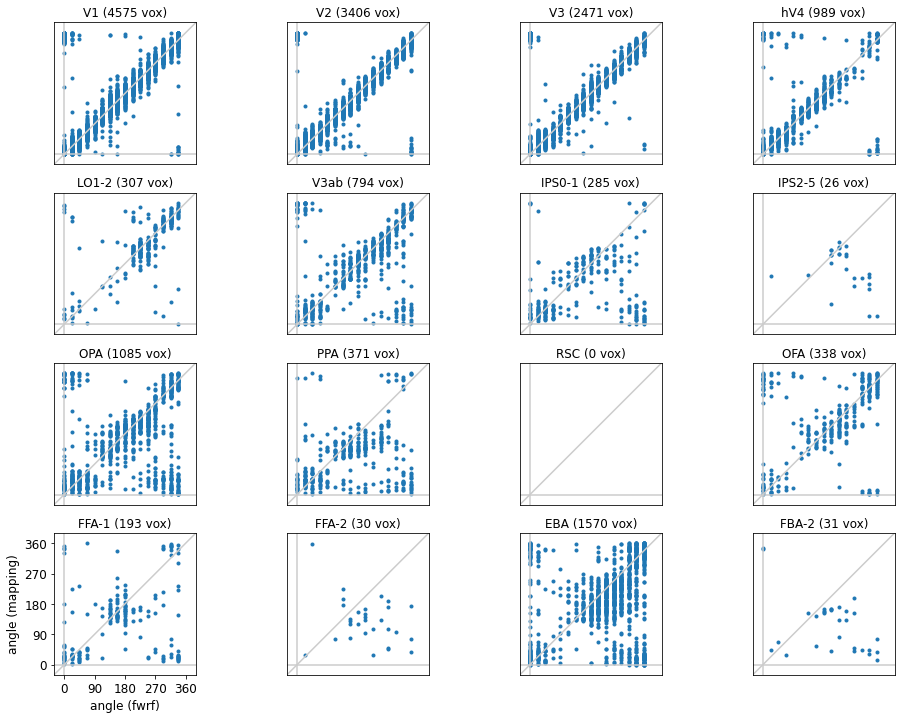

In [18]:
# Plot the correspondence between angles from the two methods.


data = np.array([angle_fwrf, angle_mapping]).T

val_r2 = np.concatenate([out[si]['val_r2'] for si in range(n_subjects)], axis=0)

# only plot fairly well-fit voxels here.
r2_thresh = 0.10
inds2use = ~no_angle & (val_r2[:,0]>r2_thresh) & (rsq_mapping>r2_thresh)

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])


single_plot_object = plot_utils.scatter_plot(xlabel='angle (fwrf)', ylabel='angle (mapping)', xlims=[-30,390], \
                 ylims=[-30,390], xticks=np.arange(0,361,90), yticks=np.arange(0,361,90),\
                 show_diagonal=True, show_axes=True, square=True)

fh = plot_utils.create_roi_subplots(data, inds2use, single_plot_object, roi_def, \
                        subject_inds=None,skip_inds=None, \
                        label_just_corner=True, figsize=(16,12))

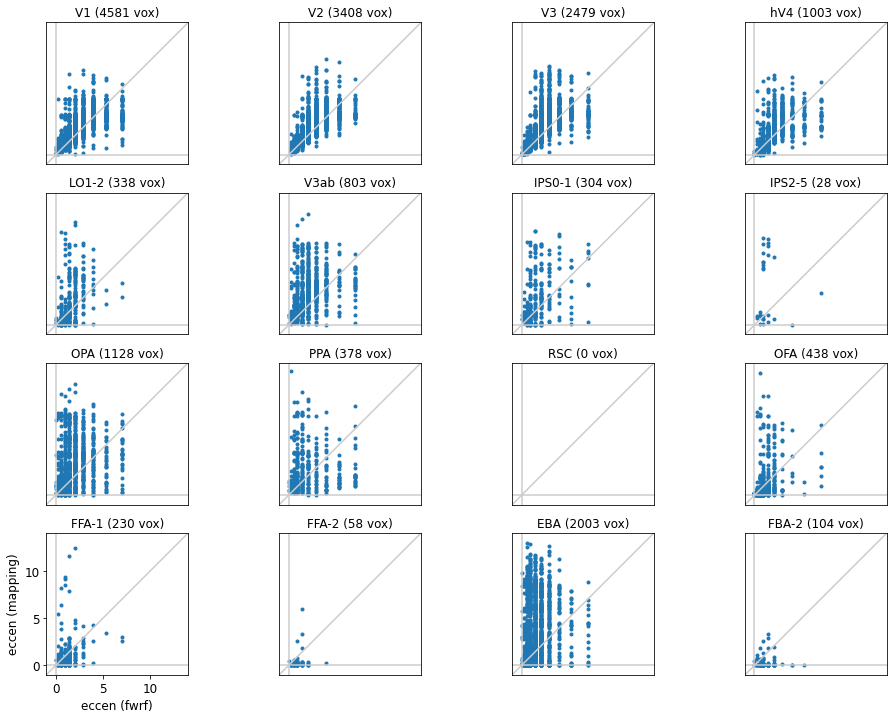

In [19]:
# Plot the correspondence between eccens from the two methods.

data = np.array([eccen_fwrf, eccen_mapping]).T

val_r2 = np.concatenate([out[si]['val_r2'] for si in range(n_subjects)], axis=0)

# only plot fairly well-fit voxels here.
r2_thresh = 0.10
inds2use = (val_r2[:,0]>r2_thresh) & (rsq_mapping>r2_thresh)

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])


single_plot_object = plot_utils.scatter_plot(xlabel='eccen (fwrf)', ylabel='eccen (mapping)', xlims=[-1,14], \
                 ylims=[-1,14], xticks=np.arange(0,11,5), yticks=np.arange(0,11,5),\
                 show_diagonal=True, show_axes=True, square=True)

fh = plot_utils.create_roi_subplots(data, inds2use, single_plot_object, roi_def, \
                        subject_inds=None,skip_inds=None, \
                        label_just_corner=True, figsize=(16,12))

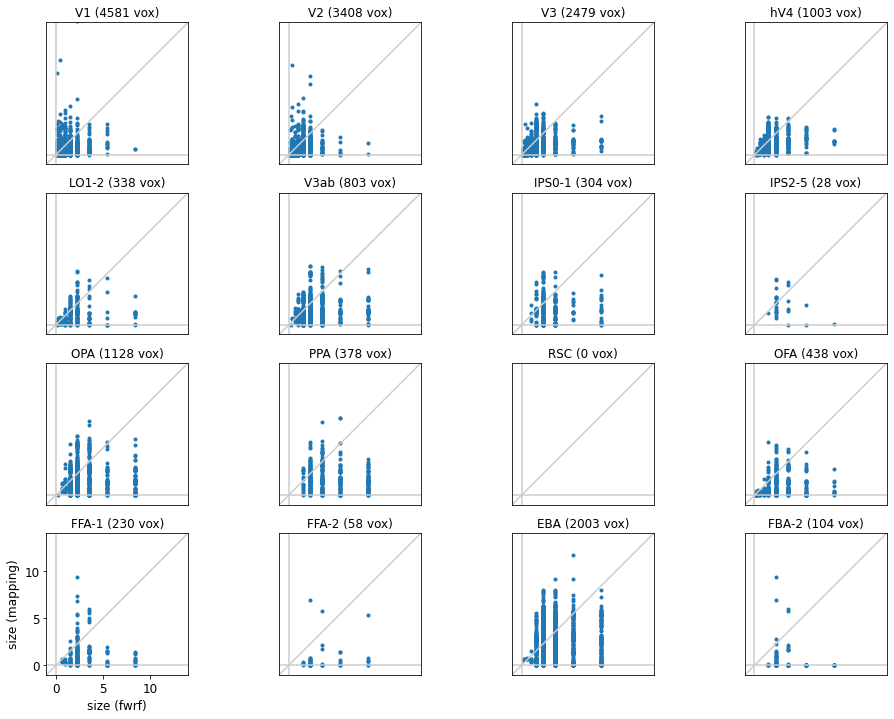

In [20]:
# Plot the correspondence between sizes from the two methods.

data = np.array([size_fwrf, size_mapping]).T

val_r2 = np.concatenate([out[si]['val_r2'] for si in range(n_subjects)], axis=0)

# only plot fairly well-fit voxels here.
r2_thresh = 0.10
inds2use = (val_r2[:,0]>r2_thresh) & (rsq_mapping>r2_thresh)

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])


single_plot_object = plot_utils.scatter_plot(xlabel='size (fwrf)', ylabel='size (mapping)', xlims=[-1,14], \
                 ylims=[-1,14], xticks=np.arange(0,11,5), yticks=np.arange(0,11,5),\
                 show_diagonal=True, show_axes=True, square=True)

fh = plot_utils.create_roi_subplots(data, inds2use, single_plot_object, roi_def, \
                        subject_inds=None,skip_inds=None, \
                        label_just_corner=True, figsize=(16,12))

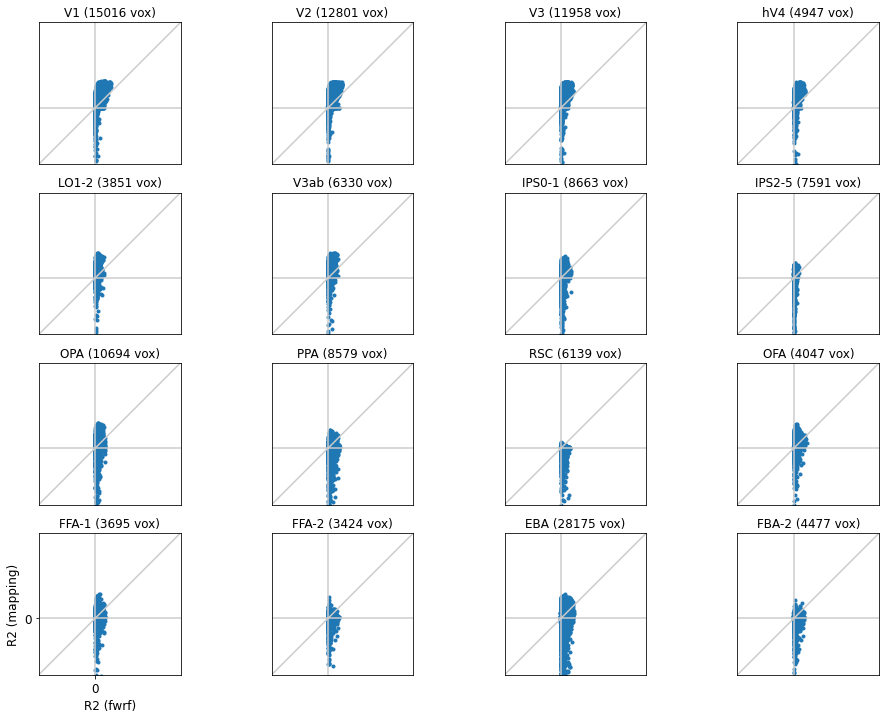

In [94]:
# Plot the relationship between R2 from the two methods.
# NOTE these are not really comparable...because they are computed with different tasks 
# (R2 for the mapping task is the percent of variance in the mapping task data that can be explained)
# but can get a sense of the distributions.

val_r2 = np.concatenate([out[si]['val_r2'] for si in range(n_subjects)], axis=0)

data = np.array([val_r2[:,0], rsq_mapping]).T
inds2use = np.ones((data.shape[0],))==1

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])

single_plot_object = plot_utils.scatter_plot(xlabel='R2 (fwrf)', ylabel='R2 (mapping)', xlims=[-2,3], \
                 ylims=[-2,3], xticks=np.arange(0,361,90), yticks=np.arange(0,361,90),\
                 show_diagonal=True, show_axes=True, square=True)

fh = plot_utils.create_roi_subplots(data, inds2use, single_plot_object, roi_def, \
                        subject_inds=None,skip_inds=None, \
                        label_just_corner=True, figsize=(16,12))

In [9]:
# Compare alexnet-FWRF params vs gabor-FWRF params

from utils import circ_utils

angle_corrs = np.zeros((n_rois,))
ecc_corrs = np.zeros((n_rois,))
x_corrs = np.zeros((n_rois,))
y_corrs = np.zeros((n_rois,))
size_corrs = np.zeros((n_rois,))

n_good_vox = np.zeros((n_rois,))

val_r2 = np.concatenate([out[si]['val_r2'] for si in range(n_subjects)], axis=0)
val_r2_gabor = np.concatenate([out_gabor[si]['val_r2'] for si in range(n_subjects)], axis=0)

r2_thresh = 0.10

for ri in range(n_rois):
    
    # only include voxels here that pass a threshold for both 
    # mapping task var explained, and FWRF model var explained.
    
    vinds = roi_def.get_indices(ri) & \
            (val_r2[:,0]>r2_thresh) & (val_r2_gabor[:,0]>r2_thresh)
    
    n_good_vox[ri] = np.sum(vinds)
    
    if np.sum(vinds)==0:
        angle_corrs[ri] = np.nan
        ecc_corrs[ri] = np.nan
        size_corrs[ri] = np.nan
        continue
        
    # removing the 0-eccen voxels for angle correlation
    angle_corrs[ri] = circ_utils.circ_corr_coef(angle_fwrf[vinds & ~no_angle]/180*np.pi, \
                                                angle_fwrf_gabor[vinds & ~no_angle]/180*np.pi)

    ecc_corrs[ri] = np.corrcoef(eccen_fwrf[vinds], eccen_fwrf_gabor[vinds])[0,1]
    size_corrs[ri] = np.corrcoef(size_fwrf[vinds], size_fwrf_gabor[vinds])[0,1]

In [10]:
import pandas as pd

prf_comparison = pd.DataFrame({'n voxels': n_good_vox.astype(int), \
                               'circ corr b/w angles': angle_corrs.round(2), \
                               'corr b/w eccens': ecc_corrs.round(2),\
                               'corr b/w sizes': size_corrs.round(2),\
                               }, index = roi_names)
prf_comparison

,n voxels,circ corr b/w angles,corr b/w eccens,corr b/w sizes
V1,4198,0.94,0.80,0.71
V2,2553,0.93,0.82,0.73
V3,1270,0.94,0.81,0.75
hV4,352,0.89,0.66,0.61
LO1-2,69,0.88,0.84,0.82
V3ab,153,0.67,0.33,0.71
IPS0-1,59,-0.09,0.30,0.29
IPS2-5,0,NaN,NaN,NaN
OPA,251,0.09,0.42,0.33
PPA,736,-0.02,0.13,0.12


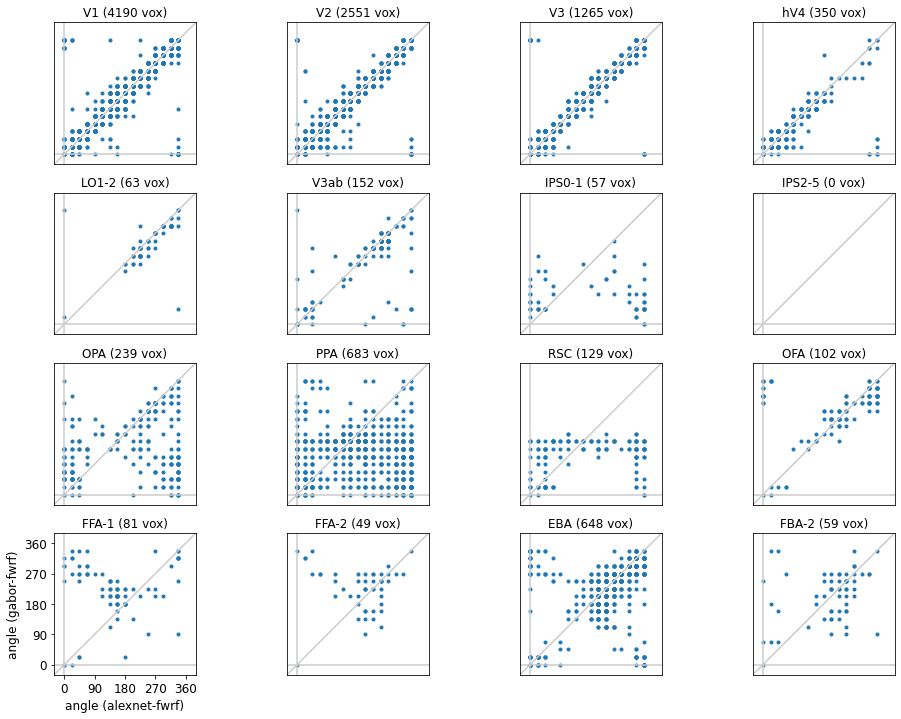

In [17]:
# Plot the correspondence between angles from the two methods.


data = np.array([angle_fwrf, angle_fwrf_gabor]).T

val_r2 = np.concatenate([out[si]['val_r2'] for si in range(n_subjects)], axis=0)

# only plot fairly well-fit voxels here.
r2_thresh = 0.10
inds2use = ~no_angle & (val_r2[:,0]>r2_thresh) & (rsq_fwrf_gabor>r2_thresh)

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])


single_plot_object = plot_utils.scatter_plot(xlabel='angle (alexnet-fwrf)', ylabel='angle (gabor-fwrf)', xlims=[-30,390], \
                 ylims=[-30,390], xticks=np.arange(0,361,90), yticks=np.arange(0,361,90),\
                 show_diagonal=True, show_axes=True, square=True)

fh = plot_utils.create_roi_subplots(data, inds2use, single_plot_object, roi_def, \
                        subject_inds=None,skip_inds=None, \
                        label_just_corner=True, figsize=(16,12))

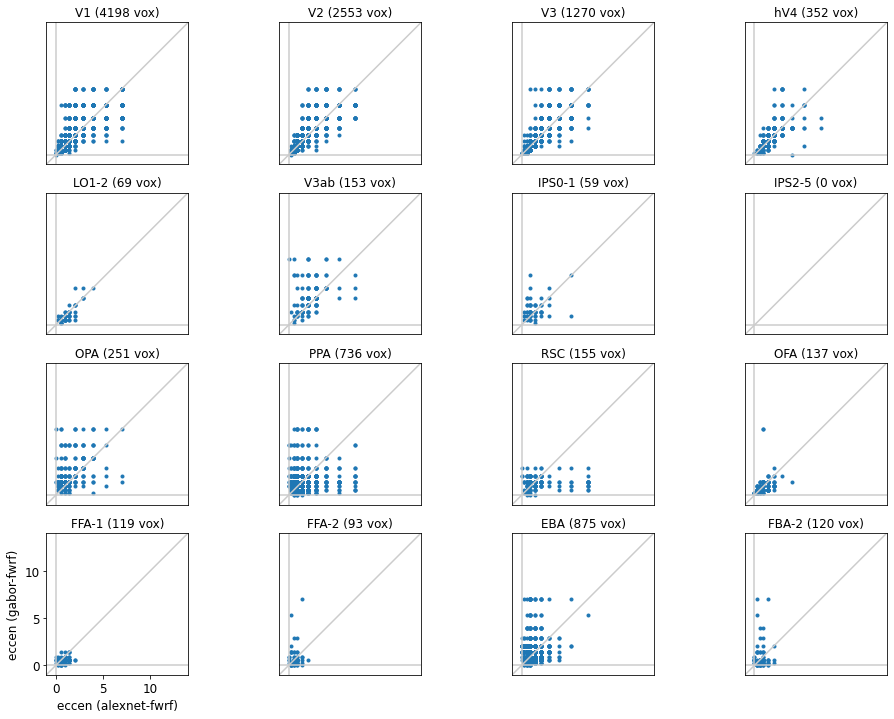

In [18]:
# Plot the correspondence between eccens from the two methods.

data = np.array([eccen_fwrf, eccen_fwrf_gabor]).T

val_r2 = np.concatenate([out[si]['val_r2'] for si in range(n_subjects)], axis=0)

# only plot fairly well-fit voxels here.
r2_thresh = 0.10
inds2use = (val_r2[:,0]>r2_thresh) & (rsq_fwrf_gabor>r2_thresh)

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])


single_plot_object = plot_utils.scatter_plot(xlabel='eccen (alexnet-fwrf)', ylabel='eccen (gabor-fwrf)', xlims=[-1,14], \
                 ylims=[-1,14], xticks=np.arange(0,11,5), yticks=np.arange(0,11,5),\
                 show_diagonal=True, show_axes=True, square=True)

fh = plot_utils.create_roi_subplots(data, inds2use, single_plot_object, roi_def, \
                        subject_inds=None,skip_inds=None, \
                        label_just_corner=True, figsize=(16,12))

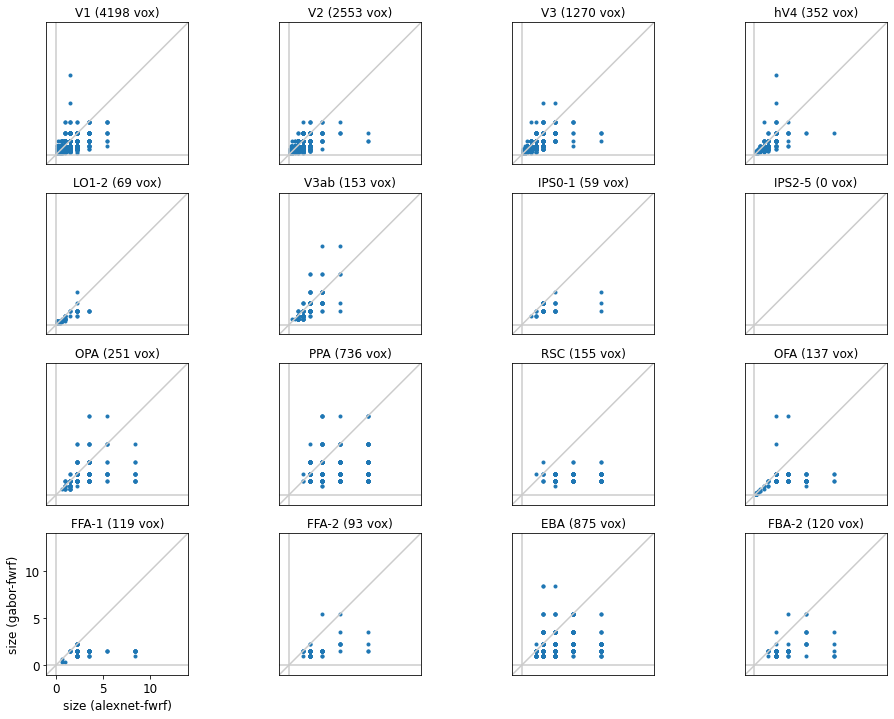

In [19]:
# Plot the correspondence between sizes from the two methods.

data = np.array([size_fwrf, size_fwrf_gabor]).T

val_r2 = np.concatenate([out[si]['val_r2'] for si in range(n_subjects)], axis=0)

# only plot fairly well-fit voxels here.
r2_thresh = 0.10
inds2use = (val_r2[:,0]>r2_thresh) & (rsq_fwrf_gabor>r2_thresh)

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])


single_plot_object = plot_utils.scatter_plot(xlabel='size (alexnet-fwrf)', ylabel='size (gabor-fwrf)', xlims=[-1,14], \
                 ylims=[-1,14], xticks=np.arange(0,11,5), yticks=np.arange(0,11,5),\
                 show_diagonal=True, show_axes=True, square=True)

fh = plot_utils.create_roi_subplots(data, inds2use, single_plot_object, roi_def, \
                        subject_inds=None,skip_inds=None, \
                        label_just_corner=True, figsize=(16,12))

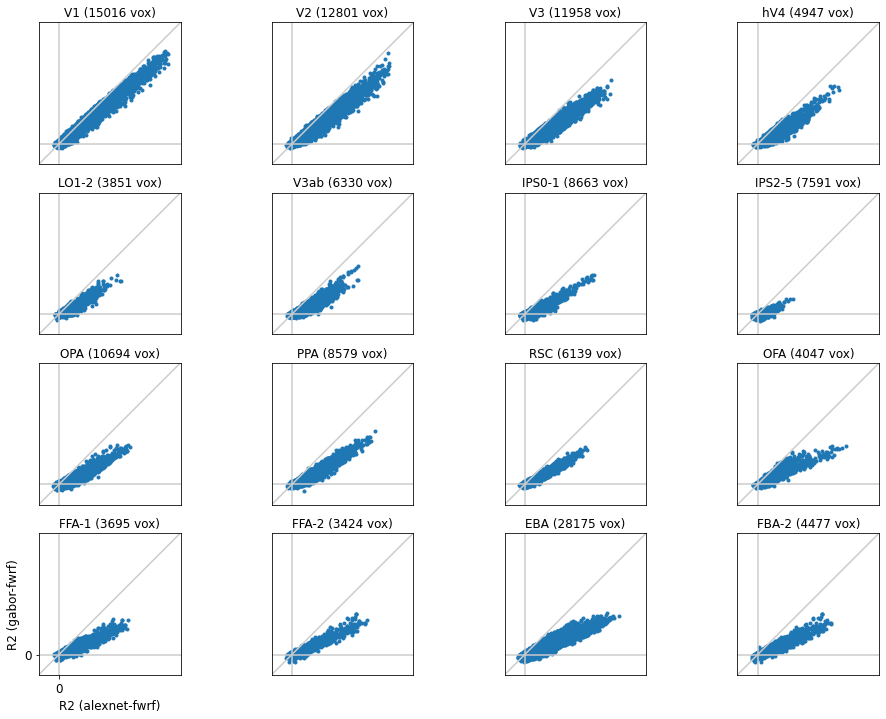

In [20]:
# Plot the relationship between R2 from the two methods.

val_r2 = np.concatenate([out[si]['val_r2'] for si in range(n_subjects)], axis=0)

data = np.array([val_r2[:,0], rsq_fwrf_gabor]).T
inds2use = np.ones((data.shape[0],))==1

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])

single_plot_object = plot_utils.scatter_plot(xlabel='R2 (alexnet-fwrf)', ylabel='R2 (gabor-fwrf)', xlims=[-0.1, 0.6], \
                 ylims=[-0.1, 0.6], xticks=np.arange(0,361,90), yticks=np.arange(0,361,90),\
                 show_diagonal=True, show_axes=True, square=True)

fh = plot_utils.create_roi_subplots(data, inds2use, single_plot_object, roi_def, \
                        subject_inds=None,skip_inds=None, \
                        label_just_corner=True, figsize=(16,12))